## Callin Switzer
10 Dec 2018
### Modified TLD script for running simulation

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import seaborn as sns
from scipy.integrate import odeint
import random
import time
from datetime import datetime
import sys
print(sys.version)
now = datetime.now()
print("last run on " + str(now))

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
last run on 2018-12-10 13:44:37.049874


In [19]:
def FlyTheBug(state,t):
    # unpack the state vector
    # displacement,x and velocity xd  etc...
    # Jorge's order .  x,y,theta,phi,xd,yd,thetad,phid
    x,xd,y,yd,theta,thetad,phi,phid, F, alpha, tau0 = state
    
    #Reynolds number calculation:
    Re_head = rhoA*(np.sqrt((xd**2)+(yd**2)))*(2*bhead)/muA; #dimensionless number
    Re_butt = rhoA*(np.sqrt((xd**2)+(yd**2)))*(2*bbutt)/muA; #dimensionless number

    #Coefficient of drag
    Cd_head = 24/np.abs(Re_head) + 6/(1 + np.sqrt(np.abs(Re_head))) + 0.4
    Cd_butt = 24/np.abs(Re_butt) + 6/(1 + np.sqrt(np.abs(Re_butt))) + 0.4
    
    h1 = m1 + m2
    h2 = (-1)*L1*m1*np.sin(theta)
    h3 = (-1)*L2*m2*np.sin(phi)
    h4 = L1*m1*np.cos(theta)
    h5 = L2*m2*np.cos(phi)
    h6 = (-1)*F*np.cos(alpha+theta)+(1/2)*Cd_butt*rhoA*S_butt* \
            np.abs(xd)*xd+(1/2)*Cd_head*rhoA*S_head*np.abs(xd)* \
            xd+(-1)*L1*m1*np.cos(theta)*thetad**2+(-1)*L2*m2*np.cos(phi)*phid**2
    h7 = g*(m1+m2)+(1/2)*Cd_butt*rhoA*S_butt*np.abs(yd)*yd+(1/2)* \
            Cd_head*rhoA*S_head*np.abs(yd)*yd+(-1)*L1*m1*thetad**2* \
            np.sin(theta)+(-1)*F*np.sin(alpha+theta)+(-1)*L2*m2*phid**2*np.sin(phi)
    h8 = (-1)*tau0+g*L1*m1*np.cos(theta)+(-1)*K*((-1)*betaR+(-1)*np.pi+(-1)* \
            theta+phi)+(-1)*c*((-1)*thetad+phid)+(-1)*F*L3*np.sin(alpha)
    h9 = tau0+g*L2*m2*np.cos(phi)+K*((-1)*betaR+(-1)*np.pi+(-1)*theta+phi)+c*((-1)*thetad+phid)
    h10 = I1+L1**2*m1
    h11 = I2+L2**2*m2

    xdd = (-1)*(h10*h11*h1**2+(-1)*h11*h1*h2**2+(-1)*h10*h1*h3**2+ \
                (-1)*h11*h1*h4**2+h3**2*h4**2+(-2)*h2* 
        h3*h4*h5+(-1)*h10*h1*h5**2+h2**2*h5**2)**(-1)*( 
        h10*h11*h1*h6+(-1)*h11*h4**2*h6+(-1)*h10*h5**2* 
        h6+h11*h2*h4*h7+h10*h3*h5*h7+(-1)*h11*h1*h2* 
        h8+(-1)*h3*h4*h5*h8+h2*h5**2*h8+(-1)*h10*h1* 
        h3*h9+h3*h4**2*h9+(-1)*h2*h4*h5*h9)
  
    ydd = (-1)*((-1)*h10*h11*h1**2+h11*h1*h2**2+h10*h1*
        h3**2+h11*h1*h4**2+(-1)*h3**2*h4**2+2*h2*h3*h4*
        h5+h10*h1*h5**2+(-1)*h2**2*h5**2)**(-1)*((-1)*h11*
        h2*h4*h6+(-1)*h10*h3*h5*h6+(-1)*h10*h11*h1*
        h7+h11*h2**2*h7+h10*h3**2*h7+h11*h1*h4*h8+(-1)*
        h3**2*h4*h8+h2*h3*h5*h8+h2*h3*h4*h9+h10*h1*
        h5*h9+(-1)*h2**2*h5*h9)
    
    thetadd = (-1)*((-1)*h10*h11*h1**2+h11*h1*h2**2+h10*h1*
        h3**2+h11*h1*h4**2+(-1)*h3**2*h4**2+2*h2*h3*h4*
        h5+h10*h1*h5**2+(-1)*h2**2*h5**2)**(-1)*(h11*h1*
        h2*h6+h3*h4*h5*h6+(-1)*h2*h5**2*h6+h11*h1*
        h4*h7+(-1)*h3**2*h4*h7+h2*h3*h5*h7+(-1)*h11*
        h1**2*h8+h1*h3**2*h8+h1*h5**2*h8+(-1)*h1*h2*
        h3*h9+(-1)*h1*h4*h5*h9);

    phidd = (-1)*((-1)*h10*h11*h1**2+h11*h1*h2**2+h10*h1*
        h3**2+h11*h1*h4**2+(-1)*h3**2*h4**2+2*h2*h3*h4*
        h5+h10*h1*h5**2+(-1)*h2**2*h5**2)**(-1)*(h10*h1*
        h3*h6+(-1)*h3*h4**2*h6+h2*h4*h5*h6+h2*h3*h4*
        h7+h10*h1*h5*h7+(-1)*h2**2*h5*h7+(-1)*h1*h2*
        h3*h8+(-1)*h1*h4*h5*h8+(-1)*h10*h1**2*h9+h1*
        h2**2*h9+h1*h4**2*h9)
    
    return(np.array([xd, xdd,yd,ydd,thetad,thetadd,phid,phidd, F, alpha, tau0]))

In [20]:
# Global variables

# Bunches of parameters ...  these don't vary from run to run 
# masses and moment of inertias in terms of insect density and eccentricity
# of the head/thorax & gaster

bhead = 0.507
ahead = 0.908
bbutt  = 0.1295
abutt  = 1.174

# cgs  density of insect 
rho = 1 

# cgs density of air
rhoA = 0.00118

# cgs viscosity
muA = 0.000186 

# Length from the thorax-abdomen joint to the center of the 
# head-thorax mass in cm
L1 = 0.908 

# Length from the thorax-abdomen joint to the center of the 
# abdomen mass in cm
L2 = 1.747  

# Length from the thorax-abdomen joint to the aerodynamic force 
# vector in cm
L3 = 0.75 

# m1 is the mass of the head-thorax
m1 = rho*(4/3)*np.pi*(bhead**2)*ahead

# m2 is the mass of the abdomen 
# (petiole + gaster)
m2 = rho*(4/3)*np.pi*(bbutt**2)*abutt

echead = ahead/bhead; #Eccentricity of head-thorax (unitless)
ecbutt = abutt/bbutt; #Eccentricity of gaster (unitless)
I1 = (1/5)*m1*(ahead**2)*(1 + echead**2); #Moment of inertia of the 
    #head-thorax
I2 = (1/5)*m2*(abutt**2)*(1 + ecbutt**2); #Moment of inertia of the gaster

#This is the surface area of the object experiencing drag.
S_head = np.pi*bhead**2

#This is the surface area of the object experiencing drag.
S_butt = np.pi*bbutt**2 

# K is the torsional spring constant of the thorax-petiole joint
# in (cm^2)*g/(rad*(s^2))
K = 29.3 

# c is the torsional damping constant of the thorax-petiole joint
# in (cm^2)*g/s
c =  14075.8   
g =  980.0   #g is the acceleration due to gravity in cm/(s^2)

# This is the resting configuration of our 
# torsional spring(s) = Initial abdomen angle - initial head angle - pi
betaR =  0.0 
    

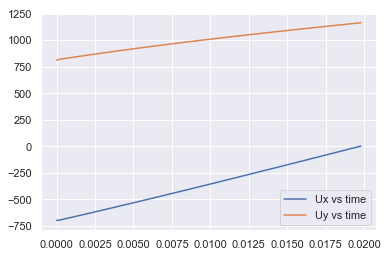

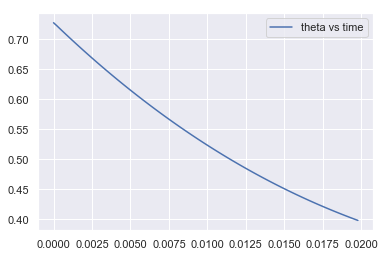

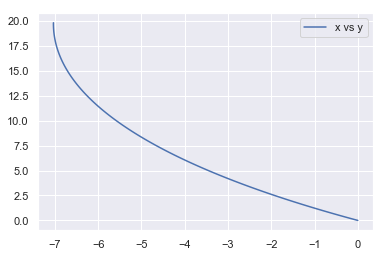

In [21]:
#This cell just checks to be sure we can run this puppy and graph results.
#  x,xd,y,yd,theta,thetad,phi,phid, F, alpha, tau0
state0 = [0.0, -697.247264, 0.0, 811.561430, 0.727497, -18.408509, 0.963598, -23.604126, 41869.951735, 6.189162, -42870.300882]  #initial conditions [x0 , v0  etc0 ]
ti = 0.0  # initial time
tf = 0.02  # final time
nstep = 100
step = (tf-ti)/nstep  # step
t = np.arange(ti, tf, step)
state = odeint(FlyTheBug, state0, t)
x = np.array(state[:,[0]])
xd = np.array(state[:,[1]])
y = np.array(state[:,[2]])
yd = np.array(state[:,[3]])
theta = np.array(state[:,[4]])
thetad = np.array(state[:,[5]])
phi = np.array(state[:,[6]])
phid = np.array(state[:,[7]])
#  And let's just plot it all
sns.set()
plt.figure()
plt.plot(t,xd, label = 'Ux vs time')
plt.plot(t,yd, label = 'Uy vs time')
plt.legend()
plt.figure()
plt.plot(t,theta, label = 'theta vs time')
plt.legend()
plt.figure()
plt.plot(x,y, label = 'x vs y')
plt.legend()


In [22]:
# get final values
x[-1], xd[-1], y[-1], yd[-1], theta[-1], phi[-1] # this checks out

(array([-7.03550703]),
 array([2.71954281]),
 array([19.82417816]),
 array([1163.63941231]),
 array([0.39816824]),
 array([0.69518568]))

In [25]:
# specify ranges
# x,xd,y,yd,
# theta,thetad,phi,phid, 
# F, alpha, tau0
ranges = np.array([[0, 0], [-1500, 1500], [0, 0], [-1500, 1500],   
                   [0, 2*np.pi], [-25, 25], [0, 2*np.pi], [-25, 25], 
                  [0, 44300], [0, 2*np.pi], [-100000, 100000]])

tic = time.time()
t = np.linspace(0, 0.02, num = 100, endpoint = False) # time cut into 100 timesteps
nrun = 100  #number of trajectories.

# initialize the matrix of 0's
zeroMatrix = np.zeros([nstep, nrun])
x,      xd,    y,   yd, \
theta, thetad, phi, phid = [zeroMatrix.copy() for ii in 
                                range(len([ "x",     "xd",     "y", "yd", 
                                            "theta", "thetad", "phi", "phid"]))]

# generate random initial conditions for state 0
state0 = np.random.uniform(ranges[:, 0], ranges[:, 1], 
                           size=(nrun, ranges.shape[0]))

# loop through all the runs
for i in range(0,nrun):
    # run ODE
    state = odeint(FlyTheBug, state0[i, :], t)
    x[i,:], xd[i,:] = state[:,0], state[:,1]
    y[i,:], yd[i, :] = state[:,2], state[:,3]
    theta[i,:], thetad[i, :] = state[:,4],state[:,5]
    phi[i,:], phid[i, :] = state[:, 6], state[:,7]
print('elapsed time = ',time.time()-tic)

elapsed time =  2.109321355819702


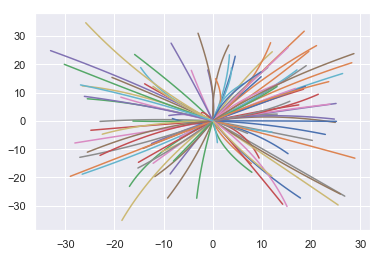

In [26]:
plt.figure()
for i in range(0,nrun):
    plt.plot(x[i, :],y[i, :], label = 'trajectory x vs y')